# 📘 Uplift Modeling to Identify Treatment Effect
---
This notebook contains the code and explanation for **Uplift Modeling to Identify Treatment Effect**.

In [7]:
segment_a = pd.read_csv("dummy_telkomsel_data.csv")
segment_a

,user_id,age,city,monthly_usage_gb,device_type,tenure_months,is_4g,segment
0,1000,56,Bandung,3.68,mid-range,44,0,C
1,1001,46,Medan,0.79,feature,15,0,B
2,1002,32,Makassar,6.38,low-end,35,1,C
3,1003,25,Jakarta,2.31,feature,48,0,C
4,1004,38,Surabaya,5.84,low-end,50,0,C
...,...,...,...,...,...,...,...,...
9995,10995,26,Medan,6.08,low-end,12,0,C
9996,10996,58,Surabaya,4.35,mid-range,37,0,C
9997,10997,35,Surabaya,4.69,high-end,9,0,C
9998,10998,46,Bandung,4.10,low-end,18,0,C


In [6]:
# Your code will go here
import pandas as pd

segment_a = pd.read_csv("dummy_telkomsel_data.csv")
segment_a = segment_a[segment_a['segment'] == 'A'].copy()

# Assign A/B group again for consistency
import numpy as np
np.random.seed(42)
segment_a['group'] = np.random.choice(['treatment', 'control'], size=len(segment_a))

# Simulate conversion again for this model
segment_a['converted'] = 0
segment_a.loc[(segment_a['group'] == 'treatment') & (np.random.rand(len(segment_a)) < 0.28), 'converted'] = 1
segment_a.loc[(segment_a['group'] == 'control') & (np.random.rand(len(segment_a)) < 0.16), 'converted'] = 1

segment_a.head()

,user_id,age,city,monthly_usage_gb,device_type,tenure_months,is_4g,segment,group,converted
23,1023,29,Medan,3.41,mid-range,32,0,A,treatment,1
38,1038,21,Jakarta,6.57,mid-range,26,0,A,control,0
41,1041,26,Makassar,6.46,mid-range,22,0,A,treatment,0
47,1047,25,Surabaya,4.10,mid-range,23,0,A,treatment,0
53,1053,21,Bandung,7.25,mid-range,33,0,A,treatment,0


In [2]:
from sklearn.preprocessing import LabelEncoder

segment_a['device_type_encoded'] = LabelEncoder().fit_transform(segment_a['device_type'])
segment_a['group_encoded'] = segment_a['group'].map({'control': 0, 'treatment': 1})

features = ['age', 'monthly_usage_gb', 'tenure_months', 'device_type_encoded']
X = segment_a[features]
treatment = segment_a['group_encoded']
y = segment_a['converted']

In [3]:
from sklearn.ensemble import RandomForestClassifier

# Model for treatment group
treat_model = RandomForestClassifier(random_state=42)
treat_model.fit(X[treatment == 1], y[treatment == 1])

# Model for control group
control_model = RandomForestClassifier(random_state=42)
control_model.fit(X[treatment == 0], y[treatment == 0])

# Predict uplift
proba_treat = treat_model.predict_proba(X)[:, 1]
proba_control = control_model.predict_proba(X)[:, 1]
uplift_score = proba_treat - proba_control

segment_a['uplift_score'] = uplift_score
segment_a[['user_id', 'group', 'converted', 'uplift_score']].head()


,user_id,group,converted,uplift_score
23,1023,treatment,1,0.66
38,1038,control,0,0.43
41,1041,treatment,0,-0.08
47,1047,treatment,0,-0.12
53,1053,treatment,0,-0.13


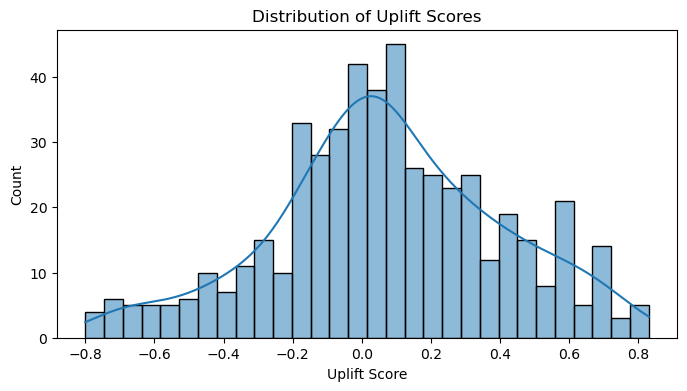

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(segment_a['uplift_score'], bins=30, kde=True)
plt.title('Distribution of Uplift Scores')
plt.xlabel('Uplift Score')
plt.show()

In [5]:
# Ambil top 30% pelanggan dengan uplift tertinggi
top_uplift = segment_a.sort_values('uplift_score', ascending=False).head(int(0.3 * len(segment_a)))
top_uplift[['user_id', 'uplift_score']].head()

,user_id,uplift_score
6930,7930,0.83
101,1101,0.83
9099,10099,0.83
7993,8993,0.78
2107,3107,0.78
